In [8]:
pip install nilearn nibabel matplotlib pandas scikit-learn

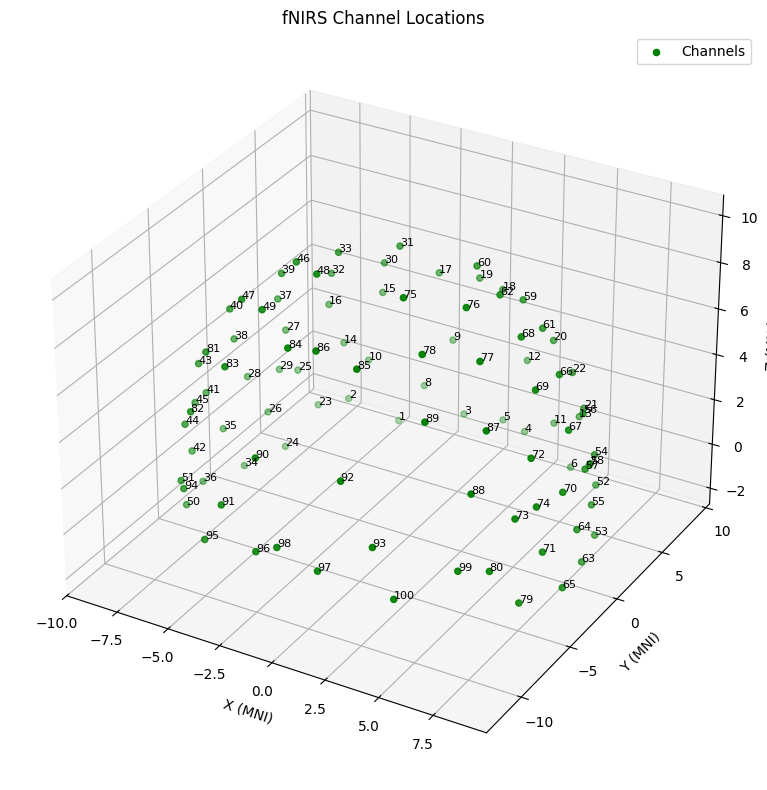

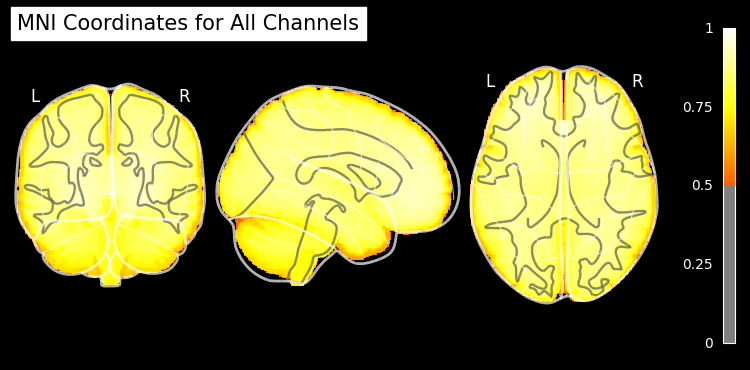

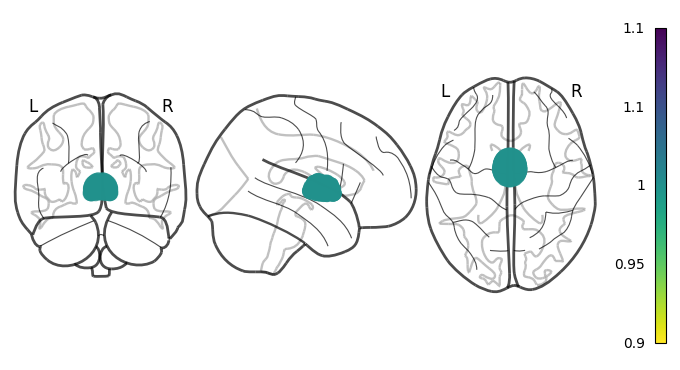

[get_dataset_dir] Dataset found in /root/nilearn_data/fsl

Channel info:
   Channel Channel_Name  Source  Detector
0        1    S1.0-D1.0     1.0       1.0
1        2    S1.0-D4.0     1.0       4.0
2        3    S2.0-D1.0     2.0       1.0
3        4    S2.0-D2.0     2.0       2.0
4        5   S2.0-D32.0     2.0      32.0

Nearest neighbors:
   Channel  Neighbor_1  Neighbor_2  Neighbor_3  Neighbor_4
0        1           8           2           3          10
1        2          23          10           1          14
2        3           5           8           4           1
3        4           5          11           6           3
4        5           4           3          11          12

MNI coordinates and region labels:
                X         Y         Z        Region_Label
Channel                                                  
1       -4.288927  7.809604 -1.697798          Background
2       -5.958871  6.016843 -0.436234          Background
3       -1.488674  8.868961 -1.056542  Subcallosal Cortex
4        1.535273  8.852039 -1.055

In [18]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances
from nilearn import plotting, datasets
import nibabel as nib
import os

# --- STEP 1: Load the .mat file ---
mat_path = "2025-02-23_001_probeInfo.mat"
if not os.path.isfile(mat_path):
    raise FileNotFoundError(f"Error: File '{mat_path}' not found.")

mat_data = scipy.io.loadmat(mat_path, struct_as_record=False, squeeze_me=True)
probe_info = mat_data['probeInfo'].probes  # fixed struct access

# --- STEP 2: Extract channel mapping ---
index_c = probe_info.index_c
channels = []
for i in range(index_c.shape[0]):
    source_idx = index_c[i, 0]
    detector_idx = index_c[i, 1]
    channel_name = f"S{source_idx}-D{detector_idx}"
    channels.append({
        'Channel': i + 1,
        'Channel_Name': channel_name,
        'Source': source_idx,
        'Detector': detector_idx
    })

channel_df = pd.DataFrame(channels)
channel_df.to_csv("channel_locations.csv", index=False)

# --- STEP 3: Extract MNI coordinates ---
coords = probe_info.coords_c3

# --- STEP 4: 3D Plot of Channels ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='green', label='Channels')

for i, (x, y, z) in enumerate(coords):
    ax.text(x, y, z, str(i + 1), color='black', fontsize=8)

ax.set_title('fNIRS Channel Locations')
ax.set_xlabel('X (MNI)')
ax.set_ylabel('Y (MNI)')
ax.set_zlabel('Z (MNI)')
ax.legend()
plt.tight_layout()
plt.show()

# --- STEP 5: Find 4 Nearest Neighbors ---
dists = pairwise_distances(coords)
np.fill_diagonal(dists, np.inf)
nearest_indices = np.argsort(dists, axis=1)[:, :4]

neighbor_df = pd.DataFrame({
    "Channel": np.arange(1, coords.shape[0] + 1),
    "Neighbor_1": nearest_indices[:, 0] + 1,
    "Neighbor_2": nearest_indices[:, 1] + 1,
    "Neighbor_3": nearest_indices[:, 2] + 1,
    "Neighbor_4": nearest_indices[:, 3] + 1,
})
neighbor_df.to_csv("nearest_neighbors.csv", index=False)

# --- STEP 6: Save MNI Coordinates ---
mni_df = pd.DataFrame(coords, columns=["X", "Y", "Z"])
mni_df.index += 1
mni_df.index.name = "Channel"
mni_df.to_csv("mni_coordinates_100_channels.csv")

# --- STEP 7: Glass brain plot ---
mni_template = datasets.load_mni152_template()
plotting.plot_glass_brain(mni_template, title='MNI Coordinates for All Channels',
                          display_mode='ortho', plot_abs=True, threshold=0.5,
                          colorbar=True, draw_cross=True, black_bg=True)

# Use node_values (can be dummy values if you want same color for all)
node_values = np.ones(coords.shape[0])  # All channels same value
plotting.plot_markers(node_coords=coords, node_values=node_values)
plotting.show()

# --- STEP 8: Map to brain regions using Harvard-Oxford Atlas ---
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr0-1mm')
atlas_img = atlas['maps']  # Already a Nifti1Image, no need to nib.load()
atlas_data = atlas_img.get_fdata()
atlas_affine = atlas_img.affine
region_names = atlas['labels']

region_labels = []
for coord in coords:
    voxel_coords = np.round(nib.affines.apply_affine(np.linalg.inv(atlas_affine), coord)).astype(int)
    try:
        value = atlas_data[tuple(voxel_coords)]
        if value < len(region_names):
            region_labels.append(region_names[int(value)])
        else:
            region_labels.append("Unknown")
    except:
        region_labels.append("Out of bounds")

mni_df['Region_Label'] = region_labels
mni_df.to_csv("mni_coordinates_with_regions.csv")

# --- Final Checks ---
print("Channel info:")
print(channel_df.head())

print("\nNearest neighbors:")
print(neighbor_df.head())

print("\nMNI coordinates and region labels:")
print(mni_df.head())
